In [1]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from utils import detect_lp
from os.path import splitext,basename
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob
from skimage.filters import threshold_local
from skimage import measure
import imutils

from matplotlib import pyplot

### Part 1: Extract license plate from sample image

In [2]:
# Load model architecture, weight and labels
json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")
print("[INFO] Model loaded successfully...")

lb = LabelEncoder()
lb.classes_ = np.load('license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [3]:
#PLACEHOLDER WPOD PLATE DETECTOR
def preprocess_image(image_path,resize=True):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    img = img / 255
    h,w,_=(img.shape)
    #print(img.shape)
    if resize:
        img = cv2.resize(img, (400,int(400*h/w)))
        print(img.shape)
    return img


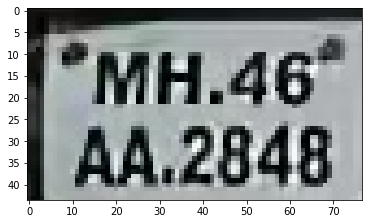

(228, 400, 3)


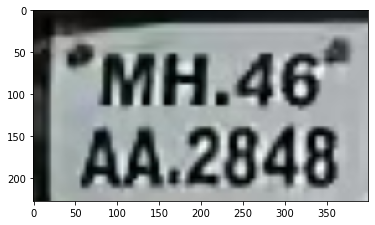

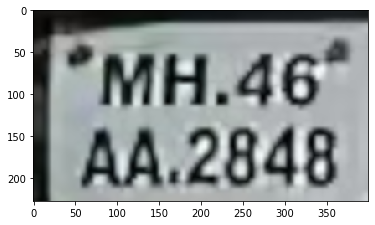

In [4]:
img = preprocess_image('croped_num_plate/17T.png')
#print(img)
#img = preprocess_image('tt.jpeg')
plt.imshow(img)
plt.show()
#print(img.shape)
kernel = np.ones((5,5),np.uint8)
#plt.imshow(0.5*img + 0.5*cv2.erode(img,kernel))
#plt.show()
i1 = 0.5*img + 0.5*cv2.dilate(img,kernel)
img = i1
plt.imshow(img)
plt.show()
LpImg =[img] 

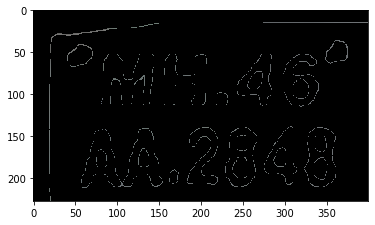

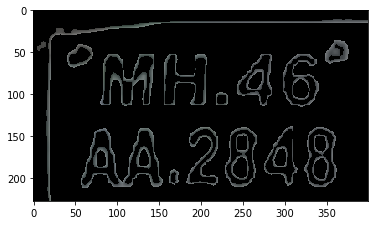

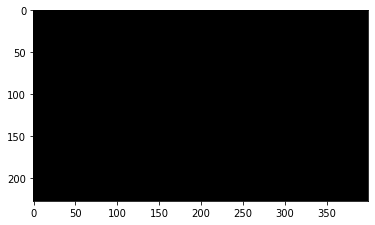

/home/sarang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


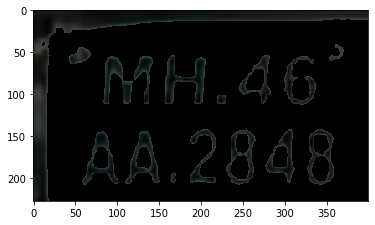

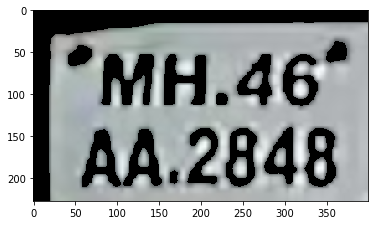

[9704, 19481, 0, 25288, 84136]
white


In [5]:
#bgcolor detection:
boundaries = [
	([99,5,0], [255,127,120]), #red
	([6, 66, 9],[117,255,136]),#green
    ([135, 90, 0], [255,255,61]),#yellow
    ([0, 0, 0], [69, 69, 69]),#black
	([100, 100, 100], [255,255,255]),#white

]

color=['red','green','yellow','black','white']

image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
#img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# loop over the boundaries
v = []
for (lower, upper) in boundaries:
    try:
        # create NumPy arrays from the boundaries
        lower = np.array(lower, dtype = "uint8")
        upper = np.array(upper, dtype = "uint8")
        # find the colors within the specified boundaries and apply
        # the mask
        mask = cv2.inRange(image, lower, upper)
        output = cv2.bitwise_and(image, image, mask = mask)

        #print(output[2])
        # show the images
        plt.imshow(output,cmap='gray')
        plt.show()
        #float(w/h) >= 0.6 and h>30
        proj = np.sum(mask,axis = 1)
        #val.append(proj)
        m = np.max(proj)
        w = 500
        p1 = 0
        result = np.zeros((proj.shape[0],500))
        for row in range(proj.shape[0]):
            #pp.append()
            #v = int(proj[row]*w/m),row)
            #if v in range(50,200)
            p = int(proj[row]*w/m)
            p1+=p
            #pts.append([p,row])
            #v2.line(result, (0,row), (p,row), (255,255,255), 1)
            #print(int(proj[row]*w/m),row)
        #print(p1)
        v.append(p1)
        #plt.imshow(result,cmap='gray')
        #plt.show()

        #plt.imshow(np.hstack([image, output]))
        #plt.show()
    except:
        v.append(0)
#plt.imshow(image)
#plt.show()
print(v)
#bg = ''
bg=color[v.index(max(v))]
print(bg)

In [6]:
#REMOVES BORDERS
import scipy.fftpack # For FFT2 

#### imclearborder definition

def imclearborder(imgBW, radius):

    # Given a black and white image, first find all of its contours
    imgBWcopy = imgBW.copy()
    _,contours,hierarchy = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST, 
        cv2.CHAIN_APPROX_SIMPLE)

    # Get dimensions of image
    imgRows = imgBW.shape[0]
    imgCols = imgBW.shape[1]    

    contourList = [] # ID list of contours that touch the border

    # For each contour...
    for idx in np.arange(len(contours)):
        # Get the i'th contour
        cnt = contours[idx]

        # Look at each point in the contour
        for pt in cnt:
            rowCnt = pt[0][1]
            colCnt = pt[0][0]

            # If this is within the radius of the border
            # this contour goes
            check1 = (rowCnt >= 0 and rowCnt < radius) or (rowCnt >= imgRows-1-radius and rowCnt < imgRows)
            check2 = (colCnt >= 0 and colCnt < radius) or (colCnt >= imgCols-1-radius and colCnt < imgCols)

            if check1 or check2:
                contourList.append(idx)
                break

    for idx in contourList:
        cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy

## IMAGE BINARIZATION

In [7]:
if(bg == 'red' or bg == 'green'):
    image=1-image

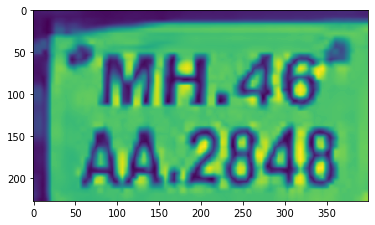

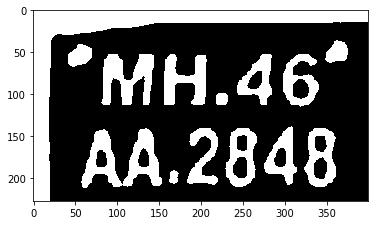

(228, 400)


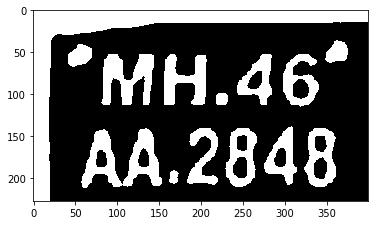

(228, 400)


In [10]:
V = cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2HSV))[2]
plt.imshow(V)
plt.show()
#blur = cv2.GaussianBlur(V,(1,1),0)#CHANGE THISSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
blur = V
_,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#T = threshold_local(V, 29, offset=15, method="gaussian")
#thresh = (V > T).astype("uint8") * 255
#thresh = cv2.bitwise_not(thresh)
kernel = np.ones((4,4),np.uint8)
# resize the license plate region to a canonical size
#plate = imutils.resize(image, width=400)
#binary = imutils.resize(thresh, width=400)
#binary = cv2.erode(thresh,kernel)
binary = thresh
#binary = cv2.erode(binary,(3,3))
#cv2.imshow("Thresh", thresh)

#kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,2))
#binary = cv2.morphologyEx(binary, cv2.MORPH_ERODE, kernel3)

plt.imshow(binary,cmap='gray')
plt.show()
print(binary.shape)
#binary=imclearborder(binary,1)
'''binary = cv2.copyMakeBorder(
    binary,
    top=8,
    bottom=10,
    left=0,
    right=0,
    borderType=cv2.BORDER_CONSTANT,
    value=0
)
binary = cv2.copyMakeBorder(
    binary,
    top=8,
    bottom=10,
    left=0,
    right=0,
    borderType=cv2.BORDER_CONSTANT,
    value=255
)
binary = cv2.copyMakeBorder(
    binary,
    top=0,
    bottom=0,
    left=2,
    right=2,
    borderType=cv2.BORDER_CONSTANT,
    value=255
)'''

#binary=imclearborder(binary,1)

plt.imshow(binary,cmap='gray')
plt.show()
print(binary.shape)

#b1 = imclearborder(binary,1)
#plt.imshow(b1,cmap='gray')
#plt.show()
#print(b1.shape)
#binary=b1
#plt.imshow(binary,cmap='gray')
#plt.show()

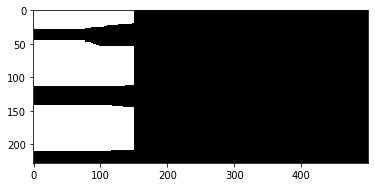

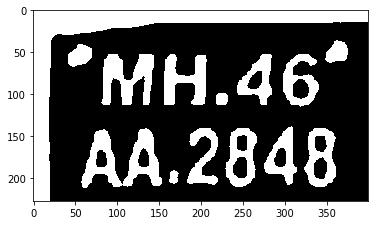

[45, 113, 141, 209]


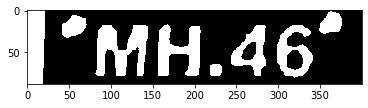

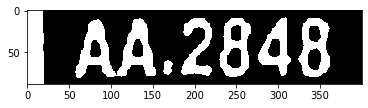

2


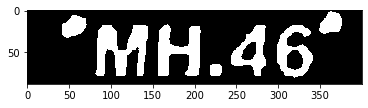

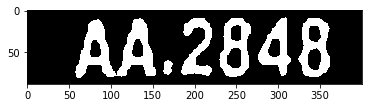

In [11]:
#DO NOT TOUCH!!!!!
#HORIZONTAL PROJECTION FOR MULTILINE DETECTION
proj = np.sum(binary,axis = 1)

m = np.max(proj)
w = 500

result = np.zeros((proj.shape[0],500))

pts = []
# Draw a line for each row
for row in range(binary.shape[0]):
    #pp.append()
    #v = int(proj[row]*w/m),row)
    #if v in range(50,200)
    p = int(proj[row]*w/m)
    if p<75:
        p=0
    elif p>150:
        p=150
    pts.append([p,row])
    cv2.line(result, (0,row), (p,row), (255,255,255), 1)
    #print(int(proj[row]*w/m),row)

plt.imshow(result,cmap='gray')
plt.show()
plt.imshow(binary,cmap='gray')
plt.show()

i=0
while pts[i][0]!=0:
    i+=1
pts = pts[i:len(pts)]
#print(pts)
c = []
for i in range(1,len(pts)):
    if pts[i][0]>0 and pts[i-1][0] == 0:
        c.append(pts[i][1])
    elif pts[i][0]==0 and pts[i-1][0] > 0:
        c.append(pts[i-1][1])
#print(c)

end = len(c)-1
bc = []
print(c)
for i in range(0,end,2):
    if c[i+1]-c[i] < 15:
        #i = i+2
        continue
    if(i+1 < len(c)):
        temp=binary[c[i]-10:c[i+1]+10,:]
        plt.imshow(temp,cmap='gray')
        plt.show()
        #h,w = temp.shape;
        #for i in range(5):
        #    for j in range(w):
        #        temp[i][j] = 0
        #        temp[h-1-i][j] = 0
        #plt.imshow(temp,cmap='gray')
        #plt.show()
        #for i in range(10):
        #    for j in range(h):
        #        temp[j][i] = 255
                #temp[j][w-1-i] = 255
        #plt.imshow(temp,cmap='gray')
        #plt.show()
        bc.append(imclearborder(temp,1))
print(len(bc))
for b in bc:
    #for i in range(5):
    #    for j in range(b.shape[1]):
    #        b[i][j] = 0
    #        b[b.shape[0]-1-i][j] = 0
    #plt.imshow(b,cmap='gray')
    #plt.show()
    #pyplot.imsave('img3.png',b,cmap='gray')
    #b = imclearborder(b,1)
    #plt.imshow(b,cmap='gray')
    #plt.show()
    opening = cv2.morphologyEx(b, cv2.MORPH_OPEN, kernel = np.ones((3,3),np.uint8))
    #b = opening
    plt.imshow(b,cmap='gray')
    plt.show()

## SEGMENTATION

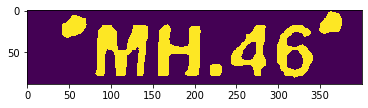

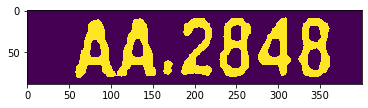

Detect 9 letters...


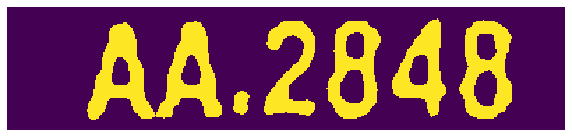

In [12]:
t1=[]
crop_characters = []
for b in bc:
    if b.any():
        bc2 = b
        plt.imshow(bc2)
        plt.show()
        # Create sort_contours() function to grab the contour of each digit from left to right
        def sort_contours(cnts,reverse = False):
            i = 0
            boundingBoxes = [cv2.boundingRect(c) for c in cnts]
            (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                                key=lambda b: b[1][i], reverse=reverse))
            return cnts

        #binary = cv2.Canny(binary,200,300)
        #plt.imshow(binary)
        _, cont, _  = cv2.findContours(bc2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #img = cv2.drawContours(binary, cont, -1, (0,0,0), 3)
        #plt.imshow(img,cmap='gray')
        #plt.show()
        plate_image = bc2
        # creat a copy version "test_roi" of plat_image to draw bounding box
        test_roi = plate_image.copy()

        # Initialize a list which will be used to append charater image


        # define standard width and height of character
        digit_w, digit_h = 30, 60
        for c in sort_contours(cont):
            (x, y, w, h) = cv2.boundingRect(c)
            ratio = h/w
            if True:# Only select contour with defined ratio
               # print(h/plate_image.shape[0])
                if h/plate_image.shape[0]>=0.55:
                    t1.append(w)
                    # Select contour which has the height larger than 50% of the plate
                    # Draw bounding box arroung digit number
                    #cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

                    # Sperate number and gibe prediction
                    curr_num = bc2[y:y+h,x:x+w]
                    #curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
                    _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                    crop_characters.append(curr_num)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
#plt.savefig('grab_digit_contour.png',dpi=300)

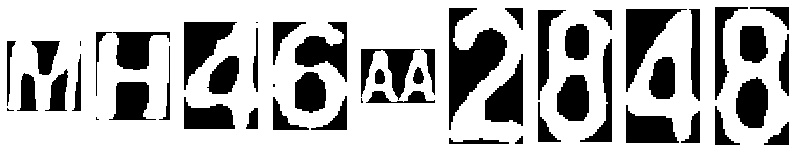

In [13]:
#print(crop_characters[1])
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    try:
        #print(crop_characters[i][1])
        fig.add_subplot(grid[i])
        plt.axis(False)
        plt.imshow(crop_characters[i],cmap="gray")
    except  Exception as e:
        print(e)
#plt.savefig("segmented_leter.png",dpi=300)    

[64, 52, 42, 43, 97, 37, 39, 39, 38]
1.0
0.8125
0.7241379310344828
0.8164556962025317
1.9303482587064678


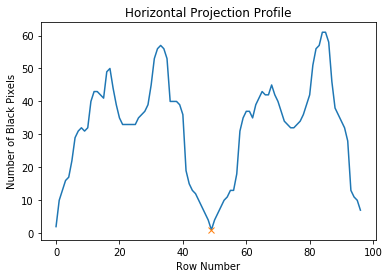

0.6208053691275167
0.6985074626865672
0.729946524064171
0.7360774818401937


In [14]:
#FORWARD- SPLIT
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
crop_characters_final=[]
print(t1)
t2=[]
avg=t1[0]
for i in range(1,len(t1)+1):
    v = (t1[i-1]/avg)
    print(v)
    avg=sum(t1[0:i])/len(t1[0:i])
    
    if v<1.5:
        crop_characters_final.append(crop_characters[i-1])
        t2.append(t1[i-1])
    else:
        counts = np.sum(crop_characters[i-1]!=0, axis=0)
        row_number = [i for i in range(crop_characters[i-1].shape[1])]
        counts = smooth(counts,1)
        plt.plot(row_number, counts, label='fit')
        plt.xlabel('Row Number')
        plt.ylabel('Number of Black Pixels')
        plt.title('Horizontal Projection Profile')
        minm,_ = scipy.signal.find_peaks(-counts)
        m=minm[0]
        for a in range(1,len(minm)):
            if counts[m] > counts[minm[a]]:
                m=minm[a]
        c1 = crop_characters[i-1][:,:m]
        c2 = crop_characters[
            i-1][:,m:]
        crop_characters_final.append(c1)
        t2.append(m)
        crop_characters_final.append(c2)
        t2.append(t1[i-1]-m)
        plt.plot(m, counts[m],'x', label='fit')
        plt.show()

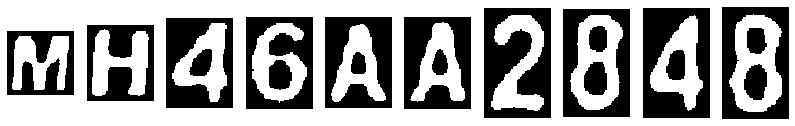

In [15]:
crop_characters=crop_characters_final
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    crop_characters[i]=cv2.copyMakeBorder(
    crop_characters[i],
    top=5,
    bottom=5,
    left=5,
    right=5,
    borderType=cv2.BORDER_CONSTANT,
    value=0
)
    #print(crop_characters[i][1])
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")

In [16]:
t1=t2
#REVERSE-SPLIT
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
#crop_characters=crop_characters_final
crop_characters.reverse()
t1.reverse()
crop_characters_final=[]
print(len(t1))
avg=t1[0]
for i in range(1,len(t1)+1):
    print(i)
    v = (t1[i-1]/avg)
    print(v)
    avg=sum(t1[0:i])/len(t1[0:i])
    
    if v<=1.5:
        crop_characters_final.append(crop_characters[i-1])
    else:
        counts = np.sum(crop_characters[i-1]!=0, axis=0)
        row_number = [i for i in range(crop_characters[i-1].shape[1])]
        counts = smooth(counts,1)
        plt.plot(row_number, counts, label='fit')
        plt.xlabel('Row Number')
        plt.ylabel('Number of Black Pixels')
        plt.title('Horizontal Projection Profile')
        minm,_ = scipy.signal.find_peaks(-counts)
        m=minm[0]
        for a in range(1,len(minm)):
            if counts[m] > counts[minm[a]]:
                m=minm[a]
        c1 = crop_characters[i-1][:,:m]
        c2 = crop_characters[i-1][:,m:]
        crop_characters_final.append(c2)
        crop_characters_final.append(c1)
        plt.plot(m, counts[m],'x', label='fit')
        plt.show()

10
1
1.0
2
1.0263157894736843
3
1.0129870129870129
4
0.956896551724138
5
1.2549019607843137
6
1.2189054726368158
7
1.032
8
1.0034129692832765
9
1.2417910447761193
10
1.4883720930232558


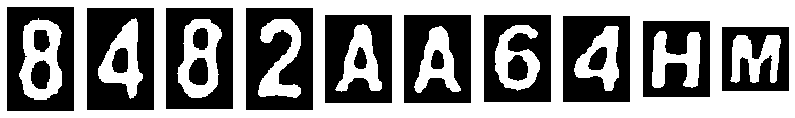

In [17]:
crop_characters=crop_characters_final
#crop_characters.reverse()
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    crop_characters[i]=cv2.copyMakeBorder(
    crop_characters[i],
    top=5,
    bottom=5,
    left=5,
    right=5,
    borderType=cv2.BORDER_CONSTANT,
    value=0
)
    #print(crop_characters[i][1])
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
#plt.savefig("segmented_leter.png",dpi=300)   

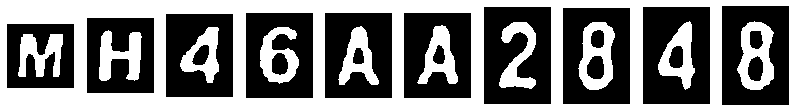

In [18]:
#FINAL
crop_characters=crop_characters_final
crop_characters.reverse()
t1.reverse()
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    crop_characters[i]=cv2.copyMakeBorder(
    crop_characters[i],
    top=5,
    bottom=5,
    left=5,
    right=5,
    borderType=cv2.BORDER_CONSTANT,
    value=0
)
    #print(crop_characters[i][1])
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
#plt.savefig("segmented_leter.png",dpi=300)   

In [19]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,lb):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = lb.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

HH46AA2848


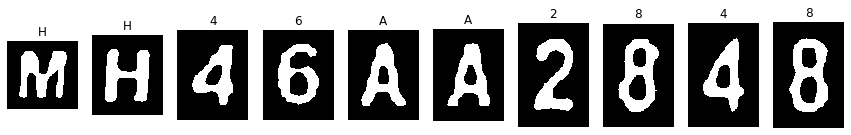

In [20]:
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,lb))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)
#plt.savefig('final_result.png', dpi=300)
#pyplot.imsave(final_string+'.png',LpImg[0])